# Import data and stuff

In [50]:
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
import seaborn as sns

In [51]:
data_df = pd.read_csv('./run2.csv')
data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["duty_cycle","speed_avg"]]
X = data_df.to_numpy()

In [52]:
data_df.corr()

,duty_cycle,speed_avg
duty_cycle,1.000000,0.869815
speed_avg,0.869815,1.000000


In [53]:
data_df

,duty_cycle,speed_avg
0,47,246.428158
1,45,259.895864
2,42,270.464729
3,42,281.724724
4,41,301.669997
...,...,...
4005,100,530.234599
4006,100,537.594669
4007,100,537.241391
4008,100,534.906953


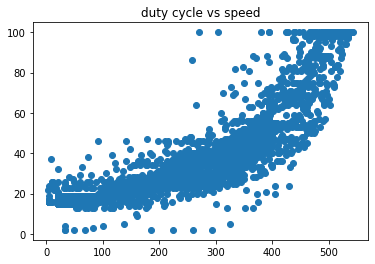

In [54]:
plt.figure()
plt.title("duty cycle vs speed")
plt.scatter(X[:,1],X[:,0]);

Given this correlation, `duty_cycle` and `speed_avg` are well correlated, but not perfectly.

In [55]:
linreg = LinearRegression()
voltage = X[:,0].reshape(-1,1)
speed = X[:,1].reshape(-1,1)
linreg.fit(speed,voltage)
predicted_voltage = linreg.predict(speed)
linreg.score(speed,voltage)

0.7565777246563734

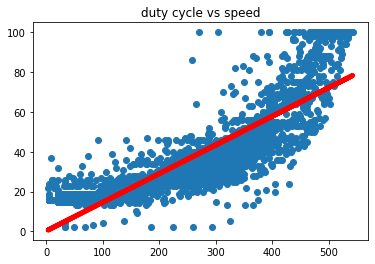

In [56]:
plt.figure()
plt.title("duty cycle vs speed")
plt.scatter(speed,voltage)
plt.plot(speed,predicted_voltage,color="red",linewidth=5.0);

In [57]:
np.sqrt(np.mean((predicted_voltage-voltage)**2))

10.790383704548834

In [58]:
speed_scaler = MinMaxScaler()
speed_scaler.fit(speed)
speed_scaled = speed_scaler.transform(speed)

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [60]:
model = keras.Sequential(
    [
        keras.Input(shape=(1,)),
        layers.Dense(12, activation="sigmoid", name="layer1"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 12)                24        
                                                                 
 out (Dense)                 (None, 1)                 13        
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.fit(speed_scaled, voltage / 100, epochs=1000)

Epoch 1/1000
125/125 [==============================] - 1s 2ms/step - loss: 0.0337
Epoch 2/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 3/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 4/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 5/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 6/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 7/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 8/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 9/1000
104/125 [=======================>......] - ETA: 0s - loss: 0.0094

KeyboardInterrupt: 

In [ ]:
test_a = speed_scaler.transform(np.array(range(600)).reshape(-1,1))
predicted_voltage = model.predict(test_a) * 100
# Y = min_max_scaler_b.inverse_transform(Y_scaled)

plt.figure()
plt.title("duty cycle vs speed")
plt.scatter(speed,voltage)
plt.plot(np.array(range(600)).reshape(-1,1),predicted_voltage,color="red",linewidth=7.0);

In [53]:
predicted_voltage = model.predict(speed_scaler.transform(speed)) * 100
np.sqrt(np.mean((predicted_voltage-voltage)**2))

9.390924860966024

Slightly better.

# With acceleration

In [62]:
data_df = pd.read_csv('./run2.csv')
data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["duty_cycle","acc","speed_avg"]]
X = data_df.to_numpy()

In [63]:
linreg = LinearRegression()
voltage = X[:,0].reshape(-1,1)
X_actual = X[:,1:]
linreg.fit(X_actual,voltage)
predicted_voltage = linreg.predict(X_actual)
linreg.score(X_actual,voltage)

0.7583845405246178

In [64]:
np.sqrt(np.mean((predicted_voltage-voltage)**2))

10.750262993837906

In [57]:
model = keras.Sequential(
    [
        keras.Input(shape=(2,)),
        layers.Dense(12, activation="sigmoid", name="layer1"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 12)                36        
                                                                 
 out (Dense)                 (None, 1)                 13        
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [65]:
X_scaler = MinMaxScaler()
X_scaler.fit(X_actual)
X_scaled = X_scaler.transform(X_actual)

In [66]:
X_scaled[:,0]

array([0.60284464, 0.58424508, 0.43873085, ..., 0.37417943, 0.51531729,
       0.59956236])

In [67]:
(X_actual[:, 0] - X_scaler.data_min_[0]) / X_scaler.data_range_[0]

array([0.60284464, 0.58424508, 0.43873085, ..., 0.37417943, 0.51531729,
       0.59956236])

In [68]:
X_scaler.data_max_, X_scaler.data_min_, X_scaler.data_range_

(array([  4.73178413, 542.65274408]),
 array([-4.02297436,  3.8461747 ]),
 array([  8.75475849, 538.80656938]))

In [69]:
model = keras.models.load_model('basic_model.h5')

In [59]:
model.fit(X_scaled, voltage / 100, epochs=1000)

Epoch 1/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0364
Epoch 2/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 3/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 4/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 5/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 6/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 7/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 8/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 9/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 10/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 11/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0089
Epoch 12/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0086
E

125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 195/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 196/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 197/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 198/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 199/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 200/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 201/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 202/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 203/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 204/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 205/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.

125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 387/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 388/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 389/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 390/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 391/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 392/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 393/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 394/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 395/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 396/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 397/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.

125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 579/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 580/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 581/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 582/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 583/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 584/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 585/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 586/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 587/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 588/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 589/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.

125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 771/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 772/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 773/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 774/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 775/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 776/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 777/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 778/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 779/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 780/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 781/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.

125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 963/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 964/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 965/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 966/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 967/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 968/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 969/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 970/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 971/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 972/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 973/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.

In [70]:
predicted_voltage = model.predict(X_scaled) * 100
np.sqrt(np.mean((predicted_voltage-voltage)**2))

7.17920633394175

In [71]:
model.predict(np.array([[1.0,-0.2]]))

array([[0.80457103]], dtype=float32)

In [72]:
predicted_voltage.argmax()

3949

In [73]:
X_scaled[3949]

array([0.8654267 , 0.98173717])

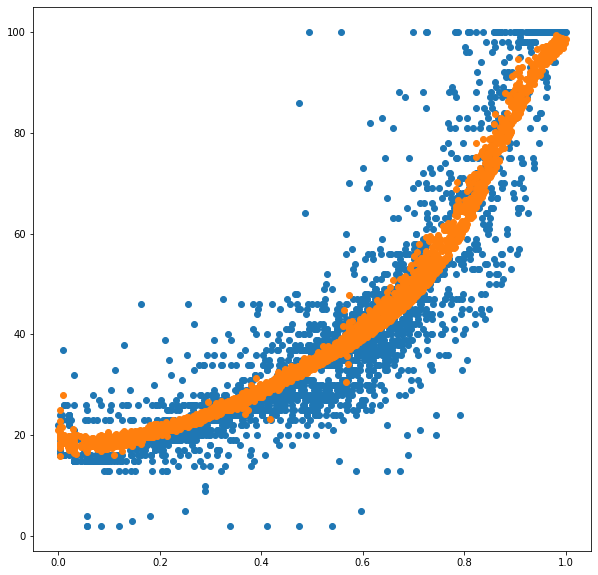

In [74]:
speed = X_scaled[:,1]
plt.figure(figsize=(10,10))
plt.scatter(speed, voltage)
plt.scatter(speed, predicted_voltage)

In [75]:
# keras.models.save_model(model, "basic_model.h5")

A tiny bit better now.

# Basic RNN

In [76]:
data_df = pd.read_csv('./run2.csv')
data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["ts","duty_cycle","acc","speed_avg"]]
X = data_df.to_numpy()

In [77]:
data_df

,ts,duty_cycle,acc,speed_avg
0,1649720766813,47,1.254785,246.428158
1,1649720766846,45,1.091950,259.895864
2,1649720766879,42,-0.181992,270.464729
3,1649720766913,42,-0.507661,281.724724
4,1649720766946,41,-1.254785,301.669997
...,...,...,...,...
4005,1649720965510,100,-0.747124,530.234599
4006,1649720965543,100,-0.977008,537.594669
4007,1649720965577,100,-0.747124,537.241391
4008,1649720965610,100,0.488504,534.906953


In [78]:
timestamps = X[:,0] 

In [79]:
ts_diffs = timestamps[1:] - timestamps[:-1]

In [80]:
N = 5

In [134]:
model = keras.Sequential(
    [
        keras.Input(shape=(N,2)),
        layers.SimpleRNN(24, name="rnnlayer"),
        layers.Dense(24, activation="sigmoid", name="layer2"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnnlayer (SimpleRNN)        (None, 24)                648       
                                                                 
 layer2 (Dense)              (None, 24)                600       
                                                                 
 out (Dense)                 (None, 1)                 25        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________


In [135]:
sequences = []
current_sequence = []

for i, diff in enumerate(ts_diffs):
    if diff < 101:
        current_sequence.append(i)
    else:
        if len(current_sequence) > N * 2:
            sequences.append(current_sequence)
        current_sequence = [i]
        
print(len(sequences))

37


In [136]:
X_relevant = X[:,2:]
Xs_scaler = MinMaxScaler()
Xs_scaler.fit(X_relevant)
X_relevant = Xs_scaler.transform(X_relevant)

In [141]:
# for sequence in sequences:

all_Xs = []
all_Ys = []
for sequence in sequences[:]:
#     if len(sequence) < 100:
#         continue
    Xs = []
    Ys = []
    for n in sequence[N:]:
        indexes_x = np.arange(n-N,n)
        index_y = n
        Ys.append(X[index_y,1])
        Xs.append(X_relevant[indexes_x])
    all_Xs += Xs
    all_Ys += Ys

all_Xs = np.array(all_Xs)
all_Ys = np.array(all_Ys).reshape(-1,1)

print(all_Xs.shape, all_Ys.shape)

model.fit(all_Xs, all_Ys/100, epochs=100, batch_size=32, verbose=2)

(3714, 5, 2) (3714, 1)
Epoch 1/100
117/117 - 0s - loss: 0.0033 - 281ms/epoch - 2ms/step
Epoch 2/100
117/117 - 0s - loss: 0.0036 - 275ms/epoch - 2ms/step
Epoch 3/100
117/117 - 0s - loss: 0.0034 - 290ms/epoch - 2ms/step
Epoch 4/100
117/117 - 0s - loss: 0.0029 - 314ms/epoch - 3ms/step
Epoch 5/100
117/117 - 0s - loss: 0.0032 - 300ms/epoch - 3ms/step
Epoch 6/100
117/117 - 0s - loss: 0.0032 - 287ms/epoch - 2ms/step
Epoch 7/100
117/117 - 0s - loss: 0.0029 - 276ms/epoch - 2ms/step
Epoch 8/100
117/117 - 0s - loss: 0.0030 - 280ms/epoch - 2ms/step
Epoch 9/100
117/117 - 0s - loss: 0.0029 - 285ms/epoch - 2ms/step
Epoch 10/100
117/117 - 0s - loss: 0.0033 - 285ms/epoch - 2ms/step
Epoch 11/100
117/117 - 0s - loss: 0.0029 - 278ms/epoch - 2ms/step
Epoch 12/100
117/117 - 0s - loss: 0.0029 - 299ms/epoch - 3ms/step
Epoch 13/100
117/117 - 0s - loss: 0.0029 - 322ms/epoch - 3ms/step
Epoch 14/100
117/117 - 0s - loss: 0.0037 - 293ms/epoch - 3ms/step
Epoch 15/100
117/117 - 0s - loss: 0.0031 - 290ms/epoch - 2ms/s

In [142]:
len(sequences[8])

599

In [143]:
rmse_sum = 0
num = 0

original_x = []
original_y = []
pred_y = []

for sequence in sequences[:]:
    print()
    X_sequence = X[np.array(sequence)]
    Xs = []
    Ys = []
    OgX = []
    for n in sequence[N:]:
        indexes_x = np.arange(n-N,n)
        index_y = n
        Ys.append(X[index_y,1])
        OgX.append(X[index_y,3])
        Xs.append(X_relevant[indexes_x])
    Xs = np.array(Xs)
    Ys = np.array(Ys).reshape(-1,1)
    print(f"len: {len(sequence)}, mean: {Ys.mean()}, std: {Ys.std()}")
    voltages_pred = model.predict(Xs) * 100
    
    original_x += OgX
    pred_y += list(voltages_pred.flatten())
    original_y += list(Ys.flatten())
    
    rmse = np.sqrt(np.mean((voltages_pred - Ys)**2))
    rmse_sum += (rmse * len(sequence))
    num += len(sequence)
    print(f"rmse: {rmse:.2f}")

print(len(original_x), len(original_y))
rmse_sum / num


len: 128, mean: 40.666666666666664, std: 8.530830425619625
rmse: 5.33

len: 124, mean: 43.134453781512605, std: 5.352960964569048
rmse: 4.24

len: 276, mean: 35.83394833948339, std: 10.927727635427411
rmse: 5.11

len: 12, mean: 28.428571428571427, std: 2.498979383505129
rmse: 3.42

len: 19, mean: 47.142857142857146, std: 2.325545799442815
rmse: 4.89

len: 15, mean: 96.7, std: 5.514526271584895
rmse: 4.61

len: 131, mean: 47.32539682539682, std: 23.022704240744947
rmse: 9.24

len: 99, mean: 19.21276595744681, std: 4.9719903553969464
rmse: 3.45

len: 599, mean: 19.365319865319865, std: 2.0936514544779636
rmse: 1.70

len: 195, mean: 24.705263157894738, std: 6.652065265702749
rmse: 3.26

len: 101, mean: 28.854166666666668, std: 3.278653072867305
rmse: 2.49

len: 68, mean: 26.96825396825397, std: 4.703825710679818
rmse: 1.84

len: 40, mean: 23.571428571428573, std: 0.49487165930539356
rmse: 1.18

len: 13, mean: 34.875, std: 0.33071891388307384
rmse: 3.48

len: 63, mean: 29.06896551724138, 

4.315953766228951

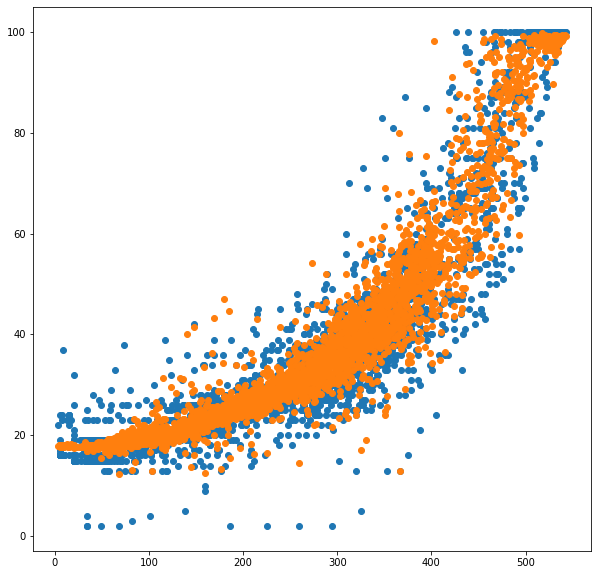

In [144]:
plt.figure(figsize=(10,10))
plt.scatter(original_x, original_y)
plt.scatter(original_x, pred_y)

In [145]:
from keras.models import save_model

save_model(model, "best_model_ever.h5")